In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Session 1: introduction to point processes

When studying wireless communications, the performance of the employed communication schemes is often measured as an averaged quantity, such as the average throughput, or the Bit Error Rate (BER). To compute the average BER on a static channel, the noise realisations should be averaged out. Fading could also comes into play, in which case the error probability is averaged on both the noise and channel realisations. Moreover, it is also possible to consider the slow time channel variations, i.e., the shadowing. 

In these three cases (noise, fading, shadowing), the average quantity can either be determined analytically through Probability Density Functions (PDFs) integration, or through numerical simulations. In these latter, the followed approach is to draw samples of the random quantities, evaluate the performance for each sample draw, and then to take the average of the performances. This approach is named a **Monte-Carlo (MC) simulation**. 

Up to now, only the random quantities affecting a single point-to-point link have been discussed. Yet, to study the averaged link quality a user faces in the network, it is important to also consider the spatial distribution of a network as a random quantity. This approach, named **stochastic geometry**, can also be performed either analytically, or by means of Monte-Carlo methods.

The aim of this first project session is to give an introduction to such network sptial distribution analysis. 

## 1.A: Average power on a regular grid

First, let us consider a regular hexagonal grid with hexagon sidelength $R$. We are first interested in studying the average power a user receives from its associated Base Station (BS). To that aim, the power model (i.e., path loss model) is defined as 

$$ P(r) = \frac{P_0}{\left(h^2+r^2\right)^{\frac{\alpha}{2}}},$$

with $r$ the distance from the BS to the user, $h$ the BS height, $P0$ the received power at $r=0$ and $\alpha$ the path loss exponent, belonging to $[2,4]$. The below function compute the received power of all the users whose distance to the BS is given in the numpy array *r*. 

In [2]:
def received_power_r(r:np.ndarray, P0: float =10.0, h: float = 1.0, alpha: float=3.0):
    #r is a 1D numpy array, being a list of distances between a BS and a user
    Pr = P0 * (h**2+r**2)**(-alpha/2)
    return Pr

The following function does the same, but based on *x* and *y* coordinates. 

In [3]:
def received_power(points:np.ndarray, P0: float =10.0, h: float = 1.0, alpha: float=3.0):
    #the point array is a N by 2 array, with each line being the coordinates of a point
    r = np.linalg.norm(points, axis=1)
    Pr = received_power_r(r,P0=P0,h=h,alpha=alpha)
    return Pr

Before moving to the numerical part, let us compute analytically the average power a user is exposed to in an hexagonal cell.

1. Considering a user with a uniform spatial distribution inside an hexagonal cell of sidelength $R$, write the integral expression giving the average power received by the user from its serving BS.
### <span style="color:red"> *Answer*</span>
Let $\mathcal{H}$ denote the surface delimited by a regular hexagon of sidelength $R$. The average received power reads as 
$$ \overline{P} = \int_{\mathcal{H}} P(r) \frac{1}{|\mathcal{H}|} \mathrm{d}\mathcal{H},$$
with $|\mathcal{H}|$ the area of $\mathcal{H}$. By symmetry, the integral can be performed on a single triangle, leading to
$$ \overline{P} =  \frac{6}{\frac{3\sqrt{3}R^2}{2}}\left(\int_{0}^{\frac{R}{2}} \int_{0}^{\sqrt{3} x} P\left(\sqrt{x^2+y^2}\right)  \mathrm{d}x\mathrm{d}y + \int_{\frac{R}{2}}^{R} \int_{0}^{\sqrt{3} (R-x)} P\left(\sqrt{x^2+y^2}\right)  \mathrm{d}x\mathrm{d}y \right).$$
This can be furthermore simplified as 
$$ \overline{P} =  \frac{4\sqrt{3}}{3 }\left(\int_{0}^{\frac{1}{2}} \int_{0}^{\sqrt{3} u} P\left(\sqrt{(Ru)^2+(Rv)^2}\right)  \mathrm{d}u\mathrm{d}v + \int_{\frac{1}{2}}^{1} \int_{0}^{\sqrt{3} (1-u)} P\left(\sqrt{(Ru)^2+(Rv)^2}\right)  \mathrm{d}u\mathrm{d}v \right),$$
and using the power model, 
$$ \overline{P} =  \frac{4\sqrt{3}P_0}{3 R^{\alpha} }\left(\int_{0}^{\frac{1}{2}} \int_{0}^{\sqrt{3} u} \left(\left(\frac{h}{R}\right)^2+u^2+v^2\right)^{-\frac{\alpha}{2}}  \mathrm{d}u\mathrm{d}v + \int_{\frac{1}{2}}^{1} \int_{0}^{\sqrt{3} (1-u)} \left(\left(\frac{h}{R}\right)^2+u^2+v^2\right)^{-\frac{\alpha}{2}}  \mathrm{d}u\mathrm{d}v \right),$$

2. This integral has no simple analytical expression. Implement the below function, computing the averaged received power for a user uniformly distributed in an hexagonal cell of radius *radius*, origin power *P0*, BS height *h*, and with a path loss exponent *alpha*.  


In [4]:
def averaged_power_hexagon_th(radius: float = 10, P0: float =10.0, h: float = 1.0, alpha: float=3.0):
    
    f = lambda y, x: received_power_r(r=np.sqrt(x**2+y**2), P0=P0, h=h, alpha=alpha)
    
    I1 = integrate.dblquad(f, 0, radius/2, 0, lambda x: np.sqrt(3)*x) 
    I2 = integrate.dblquad(f, radius/2, radius, 0, lambda x: np.sqrt(3)*(radius-x))
    
    powers_th_hex = (I1[0]+I2[0])*4/(np.sqrt(3)*radius**2)
    return powers_th_hex

3. Instead of this numerical integration, the problem can be tackled by approximating the hexagonal cell by a circular one, with the same radius. Obtain a closed-form expression of the averaged received power in this case. Will this average power be a lower or upper bound on the one for a hexagonal cell? 

### <span style="color:red"> *Answer*</span>
$$ \overline{P}_{\text{circ}} =  \frac{1}{\pi R^2} \int_{0}^{2\pi} \int_{0}^{R} P\left(r\right)  r \mathrm{d}r\mathrm{d}\theta ,\\
\iff \overline{P}_{\text{circ}} =  \frac{P_0}{ R^2} \int_{0}^{R} 2r \left(h^2+r^2\right)^{-\frac{\alpha}{2}} \mathrm{d}r = \frac{P_0}{R^{\alpha}} \int_{0}^{1} 2w \left(\left(\frac{h}{R}\right)^2+w^2\right)^{-\frac{\alpha}{2}} \mathrm{d}w,\\
\iff \overline{P}_{\text{circ}} =   \frac{P_0}{R^{\alpha}\left(1-\frac{\alpha}{2}\right)} \left[ \left(\left(\frac{h}{R}\right)^2+w^2\right)^{-\frac{\alpha}{2} +1} \right]_0^1 =   \frac{P_0}{R^{\alpha}\left(1-\frac{\alpha}{2}\right)} \left( \left(\left(\frac{h}{R}\right)^2+1\right)^{-\frac{\alpha}{2} +1}  - \left(\frac{h}{R}\right)^{-\alpha+2} \right) $$


The three above questions are related to the analytical evaluation of the communication quality. This approach can now be compared to the Monte-Carlo framework. To that aim, the Points, Cell, Hexagon and Circle classes are defined as follows.


In [5]:
@dataclass
class Points:
    """
    2D points with x and y coordinates.
    """
    array: np.ndarray
        
    @property
    def x(self) -> np.ndarray:
        return self.array[:, 0]
        
    @property
    def y(self) -> np.ndarray:
        return self.array[:, 1]
    
    def __len__(self):
        return self.array.shape[0]
    
    def draw(self, ax: Optional[plt.Axes] = None, *args, **kwargs) -> Any:
        if ax is None:
            ax = plt.gca()
        return ax.scatter(self.x, self.y, *args, **kwargs)

class Cell(ABC):
    """
    Abstract class for a cell.
    """
    @abstractmethod
    def sample(self, n: int) -> Points:
        """
        Sample uniformly n points within the current cell.
        """
        pass
    
    @abstractmethod
    def draw(self, ax: Optional[plt.Axes] = None, *args, **kwargs):
        """
        Draw the cell structure on the given axes.
        """
        pass
    
@dataclass
class Circle(Cell):
    radius: float = 1.0
    center: np.ndarray = np.array([0., 0.])
        
    def __post_init__(self):
        self.center = np.asarray(self.center).reshape(1, 2)
    
    def sample(self, n: int) -> Points:
        def sample_in_circle(n):
            xy = np.random.rand(n, 2)
            xy = (xy - .5) * (2 * self.radius)
            r = np.linalg.norm(xy, axis=1)
            
            return xy[r <= self.radius, :]
        
        n2 = n << 1
        xy = sample_in_circle(n2)
        
        while xy.shape[0] < n:
            xy = sample_in_circle(n2)
            
        return Points(array=xy[:n, :] + self.center)
    
    def draw(self, ax: Optional[plt.Axes] = None, *args, fill=False, **kwargs):
        if ax is None:
            ax = plt.gca()
        circle = plt.Circle(self.center.flatten(), self.radius, *args, fill=fill, **kwargs)
        return ax.add_patch(circle)
    
@dataclass
class Hexagon(Cell):
    radius: float = 1.0
    center: np.ndarray = np.array([0., 0.])
    rotation: float = 0.0
        
    def __post_init__(self):
        self.center = np.asarray(self.center).reshape(1, 2)
      
    @property
    def corners_centered_array(self) -> np.ndarray:
        zero = 0.
        radi = self.radius
        s3_2 = np.sqrt(3) * .5 * self.radius
        ra_2 = self.radius * .5
        array = np.array([
            [+s3_2, +ra_2],
            [+zero, +radi],
            [-s3_2, +ra_2],
            [-s3_2, -ra_2],
            [+zero, -radi],
            [+s3_2, -ra_2],
        ])
        return array
    
    @property
    def rotation_array(self) -> np.ndarray:
        cos = np.cos(self.rotation)
        sin = np.sin(self.rotation)
        
        return np.array([
            [+cos, -sin],
            [+sin, +cos],
        ])
    
    @property
    def corners_centered(self) -> Points:
        array = self.corners_centered_array
        return Points(array=array)
    
    @property
    def corners_array(self) -> np.ndarray:
        array = self.corners_centered_array
        array = (self.rotation_array @ array.T).T
        return array + self.center
        
    @property
    def corners(self) -> Points:
        array = self.corners_array
        return Points(array=array)
    
    def sample(self, n: int) -> Points:
        def sample_in_hexagon(n):
            """
            We check that points are in hexagon using
            the 'cross product trick'.
            """
            xy = np.random.rand(n, 2)
            xy = (xy - .5) * (2 * self.radius)
            corners = self.corners_centered_array
            
            # Vectors from points (samples) to each corner
            v1 = - xy[:,:,None] + corners.T[None,:,:]
            v2 = - xy[:,:,None] + np.roll(corners, 1, axis=0).T[None,:,:]
            
            cross = np.cross(v1, v2, axis=1)
            
            # Sum is 6 (or -6) if all the signs are the same
            s = np.sum(np.sign(cross), axis=1)
            index = np.abs(s) == 6
            
            return xy[index, :]
        
        n2 = n << 1
        xy = sample_in_hexagon(n2)
        
        while xy.shape[0] < n:
            xy = sample_in_hexagon(n2)
            
        xy = (self.rotation_array @ xy.T).T
            
        return Points(array=xy[:n, :] + self.center)
    
    def draw(self, ax: Optional[plt.Axes] = None, *args, fill=False, **kwargs):
        if ax is None:
            ax = plt.gca()
        hexagon = plt.Polygon(self.corners_array, *args, fill=fill, **kwargs)
        return ax.add_patch(hexagon)

This classes can be used for instance as follows. 

Text(0.5, 0, 'Received power [dB]')

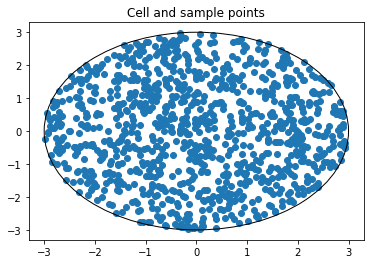

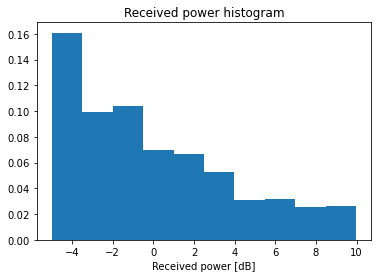

In [6]:
cell = Circle(radius=3)

points = cell.sample(1000)

plt.figure()
cell.draw()
points.draw()
plt.title('Cell and sample points')

coordinates = points.array
Power_profile = received_power(coordinates)

plt.figure()
plt.hist(10*np.log10(Power_profile), density = True)
plt.title('Received power histogram')
plt.xlabel('Received power [dB]')

4. Using the classes and functions defined below, implement a function which computes numerically the average power a user received if he is uniformly located in a cell.  

In [7]:
def averaged_power_hexagon_MC(radius: float = 10, P0: float =10.0, h: float = 1.0, alpha: float=3.0,n_samples: int = 1000):
    cell = Hexagon(radius=radius)
    points=cell.sample(n_samples)
    powers = received_power(points.array, P0 = P0, h=h, alpha=alpha)
    return np.mean(powers)

5. Before actually computing the function, one of the key parameter of a network is the BS density, in [BS/unit area]. What is the link between the cell radius $R$ and the BS density $\lambda$, for regular hexagonal cells? 

### <span style="color:red"> *Answer*</span>
The area of a regular hexagon is given by 
$$A = \frac{3 \sqrt{3}R^2}{2},$$
leading to, since $ \lambda  = \frac{1}{A}$,  
$$\lambda =\frac{2}{3 \sqrt{3}R^2}.$$

Using the above functions, compute the averaged received power for $P_0=10$, $h=1$, $\alpha = 2,3,4$, and $\lambda \in [0.004,0.4]$, both in theory and with the Monte-Carlo method. Your results should be saved in the list *hexagon_results*, structured as follows:

*[alpha_vec, lambda_vec, P0, h, powers_th_hex_0, powers_hex_0, powers_th_hex_1, powers_hex_1, ...].*

In [8]:
P0 = 10
h=1
alpha_vec = [2., 3., 4.]
lambda_vec = np.linspace(0.004, 0.4,100)
n_samples = 1000

hexagon_results = [alpha_vec,lambda_vec, P0, h] #to save the parameters and results, in order to use them later on  

for alpha in alpha_vec:
    powers_hex = []
    powers_th_hex = []
    for lam in lambda_vec:
        radius = np.sqrt(2/(3*np.sqrt(3) * lam))
        #Theoretical computation
        power_mean_th = averaged_power_hexagon_th(radius = radius, P0=P0, h=h, alpha = alpha)
        powers_th_hex.append(power_mean_th)
        
        #MC method
        power_mean = averaged_power_hexagon_MC(radius = radius, P0=P0, h=h, alpha = alpha,n_samples=n_samples)
        powers_hex.append(power_mean)
            
    hexagon_results.append(powers_th_hex)
    hexagon_results.append(powers_hex) 

Provide a graph showing the averaged received powers, in dB, as a function of the BS densities, and validate your analytical computation with the MC analysis.

Text(0, 0.5, 'Average received power')

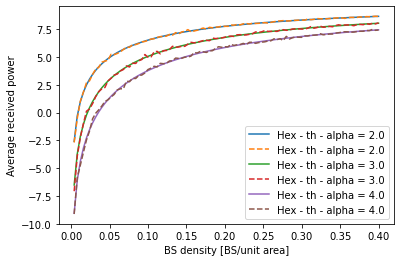

In [9]:
plt.figure()

#hexagon results
alpha_vec_hex = hexagon_results[0]
lambda_vec_hex = hexagon_results[1]
i_power_th = 4
for alpha in alpha_vec_hex:
    plt.plot(lambda_vec_hex, 10*np.log10(hexagon_results[i_power_th]), label=f"Hex - th - alpha = {alpha}")
    plt.plot(lambda_vec_hex, 10*np.log10(hexagon_results[i_power_th+1]),'--',  label=f"Hex - th - alpha = {alpha}", linestyle = '--')
    i_power_th += 2
    
plt.legend()
plt.xlabel('BS density [BS/unit area]')
plt.ylabel('Average received power')

## 1.B Average power on a random grid

In the above, the case of perfectly regular grids has been considered. Yet, this model does not reflect the inherent irregularity of real world networks. Therefore, another framework is the field of **point processes**, which enable to consider a given network topology a a realisation of a random variable. Then, the performances can be averaged out of all the network topologies. Many types of point processes exist, but we will consider in this project **Poisson Point Processes** (PPP), as they are known to provide quite tractable results. Such process is defined as follows. 

> Let $\lambda$ be the point density, express in [points/unit area], and consider a given surface $\mathcal{S}$ of area $A$. Then, a realisation of the Poisson point process with density $\lambda$ is obtained by
> - Drawing the number of points $N$ from a Poisson distribution with parameter $\lambda A$, whose PDF is given by $f(N=n) = \frac{(\lambda A)^n e^{-\lambda A}}{n!}$.
> - Picking the position of these points (i.e. $x$ and $y$ coordinates) independently and uniformly at random in $\mathcal{S}$. 

Implement the below function, which return a realisation of a Poisson point process of point density $\lambda$ in the centered square of sidelength $L$. 

In [10]:
def PPP_sampling(lam: float =0.03, L: float = 10.0):
    N = np.random.poisson(lam*L**2)
    points_init = np.random.rand(N,2)
    Points = (points_init-0.5)*L
    return Points

The following shows one realiseation of a PPP, with the BSs represented with blue dots, and the cells delimited by black lines.

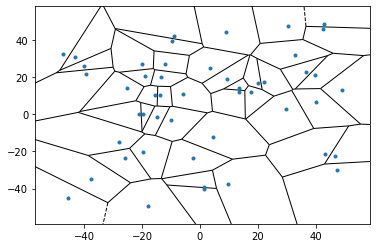

In [11]:
from scipy.spatial import Voronoi, voronoi_plot_2d

points = PPP_sampling(0.004,100)
vor = Voronoi(points)
fig = voronoi_plot_2d(vor,show_vertices=False)
plt.show()

To study the mean downlink power across a network, one should do the following. 
> Given a large region $\mathcal{S}$, a PPP with density $\lambda_{\text{BS}}$ should be generated, representing the BSs. A second PPP with density $\lambda_{\text{UE}}$ sould also be generated, being the User Equipments (UEs). Then, for each UE, the closest BS could be determined and the power could be computed. This process can be repeated $N_{\text{geo}}$ times in order to obtain different PPP realisations. 

In this procedure, the UEs located near the boundary of $\mathcal{S}$ should not be taken into account as they might suffer from boundary effects. 

Implement this Monte-Carlo sampling method in the below function, with a BS PPP of density *lam_BS*, a UE PPP of density *lam_UE*, a power *P0*, a BS height *h*, a path loss exponent *alpha*, for *N_geo* PPP draws inside a centered square of size *L*. Perform the average only on the UE located in a centered square of sidelength *L_av* to avoid boundary effect. With these parameters, this function should return the average power a user gets from its closest BS. 

In [12]:
def averaged_power_PPP_MC_v1(lam_BS: float =0.03, lam_UE: float =0.03, P0: float =10.0, h: float = 1.0, alpha: float=3.0,N_geo: int = 20, L: float = 100.0, L_av : float = 50.0):
    Power_list  = []
    
    for m in range(N_geo):
        points_BS = PPP_sampling(lam = lam_BS, L = L)
        points_UE = PPP_sampling(lam= lam_UE, L = L)
        N_UE = np.shape(points_UE)[0]
        for n in range(N_UE):
            if  np.abs(points_UE[n,0])<=L_av and np.abs(points_UE[n,1])<=L_av:
                distance = np.sqrt((points_BS[:,0]-points_UE[n,0])**2 + (points_BS[:,1]-points_UE[n,1])**2)
                d_min = np.min(distance)
                Power = received_power_r(d_min, P0 = P0, h = h, alpha = alpha)
                Power_list.append(Power)
    
    mean_power = np.mean(Power_list)
    return mean_power

Using the above functions, compute the averaged received power for $P_0=10$, $h=1$, $\alpha = 2,3,4$, $\lambda_{\text{BS}} \in [0.004,0.4]$, $\lambda_{\text{UE}}=0.03$, $L=100$, $L_{\text{av}}=50$ and $N_{\text{geo}}=20$. Save your results in the list *PPP_results_1*, structured as follows:

*[alpha_vec, lambda_vec, lambda_UE, P0, h, mean_power_0,mean_power_1, mean_power_2, ...].*

In [13]:
alpha_vec = [2., 3., 4.]
N_geo = 20
lam_UE = 0.03
P0 = 10
h = 1
L=100
L_av = 50

N_lam = 100
lambda_vec = np.linspace(0.004, 0.4,100)

PPP_results_1 = [alpha_vec,lambda_vec, lam_UE, P0, h] #to save the parameters and results, in order to use them later on  

for alpha in alpha_vec:   
    mean_power = np.zeros((N_lam,)) 
    for l in range(N_lam):
        lam = lambda_vec[l]
        mean_power[l] = averaged_power_PPP_MC_v1(lam_BS=lam, lam_UE = lam_UE, P0 = P0, h = h, alpha = alpha,N_geo = N_geo, L = L, L_av  = L_av)
    
    PPP_results_1.append(mean_power)

Provide a graph showing the averaged received powers, in dB, as a function of the BS densities, and compare your PPP results with the hexagonal ones. 

Text(0, 0.5, 'Average received power')

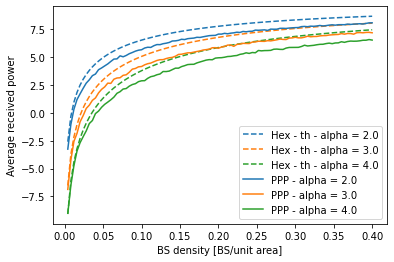

In [14]:
plt.figure()

#hexagon results
alpha_vec_hex = hexagon_results[0]
lambda_vec_hex = hexagon_results[1]
i_power_th = 4
for alpha in alpha_vec_hex:
    plt.plot(lambda_vec_hex, 10*np.log10(hexagon_results[i_power_th]), label=f"Hex - th - alpha = {alpha}", linestyle = '--')
    i_power_th += 2

plt.gca().set_prop_cycle(None) #reset color cyle
    
#PPP results - method 1
alpha_vec_PPP = PPP_results_1[0]
lambda_vec_PPP = PPP_results_1[1]
i_power_th = 5
for alpha in alpha_vec_PPP:
    plt.plot(lambda_vec_PPP, 10*np.log10(PPP_results_1[i_power_th]), label=f"PPP - alpha = {alpha}")
    i_power_th += 1


plt.legend()
plt.xlabel('BS density [BS/unit area]')
plt.ylabel('Average received power')

The above Monte-Carlo (MC) method can be simplified when one is interested in a single user, or a single BS. Indeed, one of the property of a PPP is that a single point can be added to the PPP without modifying the PPP properties. This means that without loss of generality, a UE can be added at $(x,y)=(0,0)$. Then, since this user is identical (i.e., it sees the same statistical processes) to the other users, it can be considered **typical** and the mean power can only be computed for this representative user. Yet, with respect to the first method, more geometries need to be generated since a single power realisation is obtained for each draw. 

The Monte-Carlo simulation takes then the following form. 

> Given a region $\mathcal{S}$, a PPP with density $\lambda_{\text{BS}}$ should be generated, representing the BS. A typical UE is located at $(x,y) = (0,0)$, and the power coming from the closest BS can be computed. This process is repeated $N_{\text{geo}}$ times in order to explore different PPP realisations. 

Implement this second Monte-Carlo sampling method in the below function, with a BS PPP of density *lam_BS*, a power *P0*, a BS height *h*, a path loss exponent *alpha*, for *N_geo* PPP draws inside a centered square of size *L*. With these parameters, this function should return the average power a user gets from its closest BS. 

In [15]:
def averaged_power_PPP_MC_v2(lam_BS: float =0.03, P0: float =10.0, h: float = 1.0, alpha: float=3.0,N_geo: int = 2000, L: float = 30.0):
    Power_array  = np.zeros((N_geo,))
    
    for m in range(N_geo):
        points_BS = PPP_sampling(lam = lam_BS, L = L)
        
        distance = np.sqrt((points_BS[:,0])**2 + (points_BS[:,1])**2)
        d_min = np.min(distance)
        Power_array[m] = received_power_r(d_min, P0 = P0, h = h, alpha = alpha)
        
    mean_power = np.mean(Power_array)
    return mean_power

Using the above function, compute the averaged received power for $P_0=10$, $h=1$, $\alpha = 2,3,4$, $\lambda_{\text{BS}} \in [0.004,0.4]$, $L=100$, and $N_{\text{geo}}=2000$. Save your results in the list *PPP_results_2*, structured as follows:

*[alpha_vec, lambda_vec, P0, h, mean_power_0,mean_power_1, mean_power_2, ...].*

In [16]:
alpha_vec = [2., 3., 4.]
N_geo = 2000
P0 = 10
h = 1
L=100
N_lam = 100
lambda_vec = np.linspace(0.004, 0.4,100)

PPP_results_2 = [alpha_vec,lambda_vec, P0, h] #to save the parameters and results, in order to use them later on  

for alpha in alpha_vec:   
    mean_power = np.zeros((N_lam,)) 
    for l in range(N_lam):
        lam = lambda_vec[l]
        mean_power[l] = averaged_power_PPP_MC_v2(lam_BS=lam, P0 = P0, h = h, alpha = alpha,N_geo = N_geo, L = L)
    
    PPP_results_2.append(mean_power)

Provide a graph showing the averaged received powers, in dB, as a function of the BS densities, for the hexagonal cells, the first MC method and the second Verify that both PPP methods indeed gives the same results. 

Text(0, 0.5, 'Average received power')

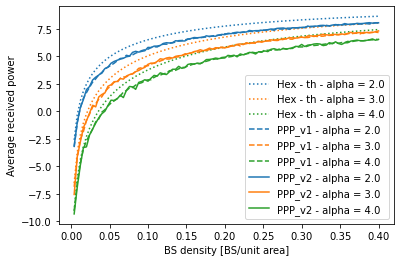

In [17]:
plt.figure()

#hexagon results
alpha_vec_hex = hexagon_results[0]
lambda_vec_hex = hexagon_results[1]
i_power_th = 4
for alpha in alpha_vec_hex:
    plt.plot(lambda_vec_hex, 10*np.log10(hexagon_results[i_power_th]), label=f"Hex - th - alpha = {alpha}", linestyle = 'dotted')
    i_power_th += 2

plt.gca().set_prop_cycle(None) #reset color cyle
    
#PPP results - method 1
alpha_vec_PPP = PPP_results_1[0]
lambda_vec_PPP = PPP_results_1[1]
i_power_th = 5
for alpha in alpha_vec_PPP:
    plt.plot(lambda_vec_PPP, 10*np.log10(PPP_results_1[i_power_th]), label=f"PPP_v1 - alpha = {alpha}", linestyle = '--')
    i_power_th += 1

plt.gca().set_prop_cycle(None) #reset color cyle
    
#PPP results - method 2
alpha_vec_PPP_2 = PPP_results_2[0]
lambda_vec_PPP_2 = PPP_results_2[1]
i_power_th = 4
for alpha in alpha_vec_PPP_2:
    plt.plot(lambda_vec_PPP_2, 10*np.log10(PPP_results_2[i_power_th]), label=f"PPP_v2 - alpha = {alpha}")
    i_power_th += 1
    

plt.legend()
plt.xlabel('BS density [BS/unit area]')
plt.ylabel('Average received power')

To conclude this part, it should be emphasised that the Poisson property of the PPP have not be utilised, and that any other point process could have been considered in the above. In fact, the Poisson property of a PPP is particularly useful when considering such problem from their analytic counterparts. Yet, such analytic development is not the aim of this project and we will always consider Monte-Carlo simulations to evaluate the performances in the following. 

## 1.C Power distribution

While the average power is an interesting quantity, it does not capture the full experience of a UE. Indeed, for the same average value, one could encounter very low and very high power values, or experience an almost constant power level. Hence, it is often interesting to compute the full Probability Density Function (PDF) of the quantity of interest, here the received power.

For $\alpha = 3$, compute a list of received power realisation for $P_0=10$, $h=1$, $\lambda_{\text{BS}} \in [0.004, 0.2 ,0.4]$, $L=100$, and $N_{\text{geo}}=20000$. Do this for the hexagon case, and the PPP case. Save your results in the list *Density_results*, structured as follows:

*[alpha, lambda_vec, P0, h, powers_hex_0, powers_PPP_0, powers_hex_1, powers_PPP_1 ...].*

In [18]:
alpha = 3.0
N_geo = 20000
P0 = 10
h = 1
L=100
lambda_vec = np.array([0.004, 0.2, 0.4])
N_lam = len(lambda_vec)

Density_results = [alpha,lambda_vec, P0, h] #to save the parameters and results, in order to use them later on  

for l in range(N_lam):
    lam = lambda_vec[l]
    
    #Hexagons 
    radius = np.sqrt(2/(3*np.sqrt(3) * lam))
    cell = Hexagon(radius=radius)
    points=cell.sample(N_geo)
    powers_hex = received_power(points.array, P0 = P0, h=h, alpha=alpha)    
    Density_results.append(powers_hex)
    
    #PPP
    powers_PPP = np.zeros((N_geo,))
    for m in range(N_geo):
        points_BS = PPP_sampling(lam = lam, L = L)
        distance = np.sqrt((points_BS[:,0])**2 + (points_BS[:,1])**2)
        d_min = np.min(distance)
        powers_PPP[m] = received_power_r(d_min, P0 = P0, h = h, alpha = alpha)
    
    Density_results.append(powers_PPP)

From the power realisations computed above, draw an histogram of the received power, in dB, for the different densities. Compare the distributions of the hexagonal cell and the results obtained through the PPP approach.

Text(0.5, 1.0, 'Received power PDF')

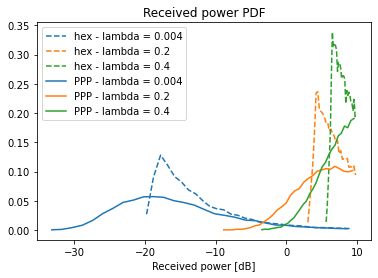

In [19]:
plt.figure()
n_bins = 30

lambda_vec = Density_results[1]
i_power = 4
for lam in lambda_vec:
    powers_hex = Density_results[i_power]
    hist_hex, bin_edges_hex = np.histogram(10*np.log10(powers_hex), bins = n_bins,density = True)
    plt.plot(bin_edges_hex[:-1],hist_hex,'--', label=f"hex - lambda = {lam}")
    i_power+=2

plt.gca().set_prop_cycle(None) #reset color cyle
    
i_power = 5
for lam in lambda_vec:
    Power_array = Density_results[i_power]
    hist_PPP, bin_edges_PPP = np.histogram(10*np.log10(Power_array), bins = n_bins,density = True)
    plt.plot(bin_edges_PPP[:-1],hist_PPP, label=f"PPP - lambda = {lam}")
    i_power+=2
    
plt.legend()
plt.xlabel('Received power [dB]')
plt.title('Received power PDF')

The above figure shows a representation of the PDF of the received power. Yet, people are most often concerned about ensuring some value is about a threshold (large enough rate, large enough SINR, low enough exposure, etc.). Therefore, it is sometimes more useful to compute the complementary cumulative distribution function, i.e. $\mathbb{P}\left[X\geq x\right]$. Obtain such figure from the above PDFs. 

Text(0.5, 1.0, 'Received power CCDF')

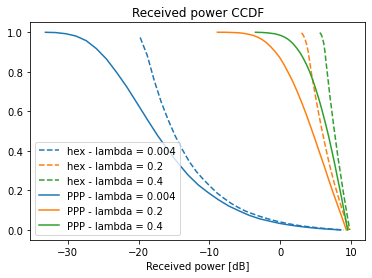

In [20]:
plt.figure()
n_bins = 30

lambda_vec = Density_results[1]
i_power = 4
for lam in lambda_vec:
    powers_hex = Density_results[i_power]
    hist_hex, bin_edges_hex = np.histogram(10*np.log10(powers_hex), bins = n_bins,density = True)
    
    CDF_hex = np.cumsum(hist_hex*np.diff(bin_edges_hex))
    CCDF_hex = 1-CDF_hex
    plt.plot(bin_edges_hex[:-1],CCDF_hex, '--', label=f"hex - lambda = {lam}")
    
    i_power+=2

plt.gca().set_prop_cycle(None) #reset color cyle
    
i_power = 5
for lam in lambda_vec:
    Power_array = Density_results[i_power]
    hist_PPP, bin_edges_PPP = np.histogram(10*np.log10(Power_array), bins = n_bins,density = True)
    
    CDF_PPP = np.cumsum(hist_PPP*np.diff(bin_edges_PPP))
    CCDF_PPP = 1-CDF_PPP
    plt.plot(bin_edges_PPP[:-1],CCDF_PPP, label=f"PPP - lambda = {lam}")
    
    
    i_power+=2
    
plt.legend()
plt.xlabel('Received power [dB]')
plt.title('Received power CCDF')

## 1.D Average exposure on a random grid

The above focuses on the average power received from the BS serving a UE. While this is already very interesting, this does not fully use the power of the framework of point processes. Indeed, a single user and a singly BS are considered, and thus one could avoir generating the whole network to evaluate the performance.  

To investigate the use of point processes, one can consider the exposure a UE gets in a network, i.e. the sum of the power coming from all the BSs. 

Implement a Monte-Carlo method investigating how the exposure evolves with the BS density, for $P_0=10$, $h=1$, $\alpha = 2,3,4$, and $\lambda \in [0.004,0.4]$, and $N_{\text{geo}} = 2000$. Consider only the second way of doing the Monte-Carlo simulation, i.e., with a centered typical user. You can use a square $\mathcal{S}$ of length $100$. 

In [21]:
def averaged_exposure_PPP_MC(lam_BS: float =0.03, P0: float =10.0, h: float = 1.0, alpha: float=3.0,N_geo: int = 2000, L: float = 30.0):
    Exposure_array  = np.zeros((N_geo,))
    
    for m in range(N_geo):
        points_BS = PPP_sampling(lam = lam_BS, L = L)
        
        distance = np.sqrt((points_BS[:,0])**2 + (points_BS[:,1])**2)
        Powers = received_power_r(distance, P0 = P0, h = h, alpha = alpha)
        Exposure_array[m] = np.sum(Powers)
        
    mean_exposure = np.mean(Exposure_array)
    return mean_exposure

In [22]:
alpha_vec = [2., 3., 4.]
N_geo = 2000
P0 = 10
h = 1
L=100
N_lam = 100
lambda_vec = np.linspace(0.004, 0.4,100)

PPP_results_exposure = [alpha_vec,lambda_vec, P0, h] #to save the parameters and results, in order to use them later on  

for alpha in alpha_vec:   
    mean_exposure = np.zeros((N_lam,)) 
    for l in range(N_lam):
        lam = lambda_vec[l]
        mean_exposure[l] = averaged_exposure_PPP_MC(lam_BS=lam, P0 = P0, h = h, alpha = alpha,N_geo = N_geo, L = L)
    
    PPP_results_exposure.append(mean_exposure)

Text(0, 0.5, 'Average exposure')

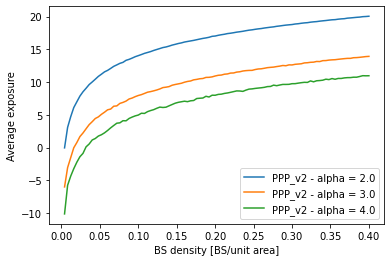

In [23]:
#PPP results
alpha_vec_PPP_2 = PPP_results_exposure[0]
lambda_vec_PPP_2 = PPP_results_exposure[1]
i_power_th = 4
for alpha in alpha_vec_PPP_2:
    plt.plot(lambda_vec_PPP_2, 10*np.log10(PPP_results_exposure[i_power_th]), label=f"PPP_v2 - alpha = {alpha}")
    i_power_th += 1
    
plt.legend()
plt.xlabel('BS density [BS/unit area]')
plt.ylabel('Average exposure')

In [24]:
#Implement Monte-Carlo simulation - exposure
alpha = 2.0
N_geo = 20000
P0 = 10
h = 1
L=100
lambda_vec = np.array([0.004, 0.2, 0.4])
N_lam = len(lambda_vec)

Density_exp_results = [alpha,lambda_vec, P0, h] #to save the parameters and results, in order to use them later on  

for l in range(N_lam):
    lam = lambda_vec[l]
    
    #PPP
    Exposure_PPP = np.zeros((N_geo,))
    for m in range(N_geo):
        points_BS = PPP_sampling(lam = lam, L = L)
        distance = np.sqrt((points_BS[:,0])**2 + (points_BS[:,1])**2)
        powers = received_power_r(distance, P0 = P0, h = h, alpha = alpha)
        Exposure_PPP[m] = np.sum(powers)
        
    Density_exp_results.append(Exposure_PPP)

Text(0.5, 1.0, 'Exposure PDF')

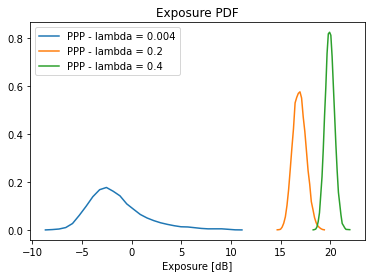

In [25]:
plt.figure()
n_bins = 30

lambda_vec = Density_exp_results[1]
i_power = 4
for lam in lambda_vec:
    Exp_array = Density_exp_results[i_power]
    hist_PPP, bin_edges_PPP = np.histogram(10*np.log10(Exp_array), bins = n_bins,density = True)
    plt.plot(bin_edges_PPP[:-1],hist_PPP, label=f"PPP - lambda = {lam}")
    i_power+=1
    
plt.legend()
plt.xlabel('Exposure [dB]')
plt.title('Exposure PDF')

Text(0.5, 1.0, 'Exposure CCDF')

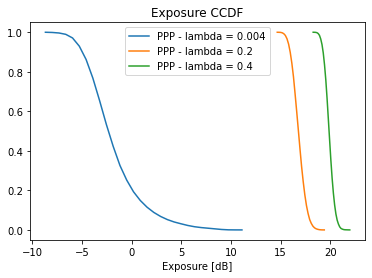

In [26]:
plt.figure()
n_bins = 30

i_power = 4
for lam in lambda_vec:
    Exp_array = Density_exp_results[i_power]
    hist_PPP, bin_edges_PPP = np.histogram(10*np.log10(Exp_array), bins = n_bins,density = True)
    
    CDF_PPP = np.cumsum(hist_PPP*np.diff(bin_edges_PPP))
    CCDF_PPP = 1-CDF_PPP
    plt.plot(bin_edges_PPP[:-1],CCDF_PPP, label=f"PPP - lambda = {lam}")
    
    
    i_power+=1
    
plt.legend()
plt.xlabel('Exposure [dB]')
plt.title('Exposure CCDF')